In [1]:
import numpy as np
import cupy as cp
import h5py
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import remove_outliers
##!jupyter nbconvert --to script config_template.ipynb
import sys


astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension
pad = 768
npos= 16

detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 1.286e-3
z1 = np.tile(5.5e-3-sx0, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = n+2*pad#1024//(2048//n)#2*pad
show = True
lam1 = 1e-1
lam2 = 0
gpu=1
crop=ne//2-n//2

# lam1=float(sys.argv[1])
# lam2=float(sys.argv[2])
# gpu = int(sys.argv[3])
cp.cuda.Device(gpu).use()

flg = f'{n}'
path = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_003p3nm_1000ms_01/'
path_ref = f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_003p3nm_1000ms_01/'
path_out = f'/data/vnikitin/ESRF/ID16A/20240924_rec/SiemensLH/SiemensLH_003p3nm_1000ms_01_{flg}/'

## Read data

In [3]:
with h5py.File(f'{path}SiemensLH_003p3nm_1000ms_010000.h5') as fid:
    data0 = fid['/entry_0000/measurement/data'][:npos].astype('float32')
    
with h5py.File(f'{path_ref}ref_0000.h5') as fid:
    ref0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}/dark_0000.h5') as fid:
    dark0 = fid['/entry_0000/measurement/data'][:].astype('float32')
with h5py.File(f'{path}SiemensLH_003p3nm_1000ms_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

data0 = data0[np.newaxis]
shifts_code0 = np.zeros([1,npos,2],dtype='float32')
shifts_code0[:,:,1] = spy
shifts_code0[:,:,0] = -spz




In [4]:
import cupyx.scipy.ndimage as ndimage
def remove_outliers(data, dezinger, dezinger_threshold):    
    data_gpu = cp.array(data)
    if (int(dezinger) > 0):
        w = int(dezinger)
        # print(data.shape)
        fdata = ndimage.median_filter(data_gpu, [1,w, w])
        print(np.sum(np.abs(data_gpu-fdata)>fdata*dezinger_threshold))
        data_gpu = np.where(np.abs(data_gpu-fdata)>fdata*dezinger_threshold, fdata, data_gpu)
    return data_gpu.get()

221
205
205
203
217
215
193
207
209
196
195
209
212
195
201
199
154


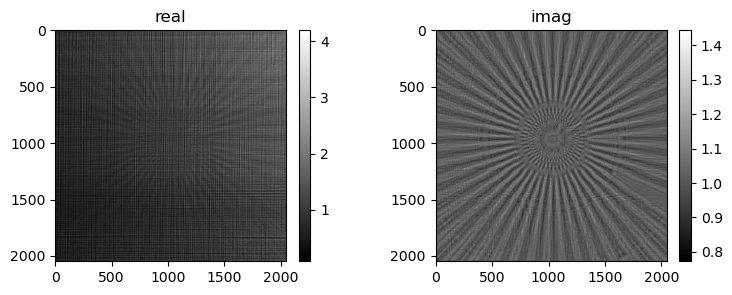

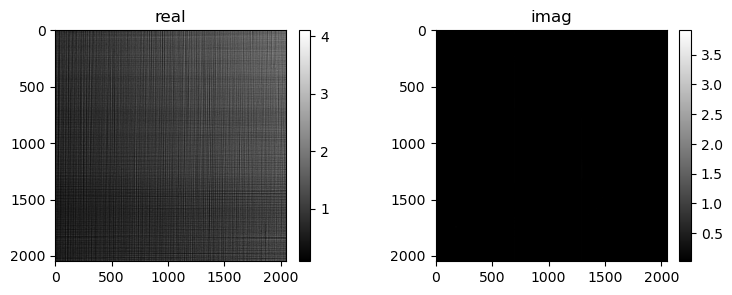

In [5]:
data = data0.copy()
ref = ref0.copy()
dark = dark0.copy()
dark = np.mean(dark,axis=0)[np.newaxis]
ref = np.mean(ref,axis=0)[np.newaxis]
data-=dark
ref-=dark

data[data<0]=0
ref[ref<0]=0

data[:,:,1320:1320+25,890:890+25] = data[:,:,1280:1280+25,890:890+25]
ref[:,1320:1320+25,890:890+25] = ref[:,1280:1280+25,890:890+25]

for k in [1379]:
    data[:,:,0::2,k] = (data[:,:,0::2,k-1]+data[:,:,0::2,k+1])*0.5
    ref[:,0::2,k]=(ref[:,0::2,k-1]+ref[:,0::2,k+1])*0.5

for k in [2086,3876]:
    data[:,:,1::2,k] = (data[:,:,1::2,k-1]+data[:,:,1::2,k+1])*0.5
    ref[:,1::2,k]=(ref[:,1::2,k-1]+ref[:,1::2,k+1])*0.5

for k in [356]:    
    data[:,:,k,:] = (data[:,:,k-1,:]+data[:,:,k+1,:])*0.5
    ref[:,k,:] = (ref[:,k-1,:]+ref[:,k+1,:])*0.5
for k in range(npos):
    radius = 7
    threshold = 0.75
    dxchange.write_tiff(data[:,k],'/data2/tmp/t1',overwrite=True)
    data[:,k] = remove_outliers(data[:,k], radius, threshold)
    dxchange.write_tiff(data[:,k],'/data2/tmp/t2',overwrite=True)
    
ref[:] = remove_outliers(ref[:], radius, threshold)     

data/=np.mean(ref)
dark/=np.mean(ref)
ref/=np.mean(ref)

data = (data[:,:,::3]+data[:,:,1::3]+data[:,:,2::3])/3
data = (data[:,:,:,::3]+data[:,:,:,1::3]+data[:,:,:,2::3])/3
ref = (ref[:,::3]+ref[:,1::3]+ref[:,2::3])/3
ref = (ref[:,:,::3]+ref[:,:,1::3]+ref[:,:,2::3])/3
dark = (dark[:,::3]+dark[:,1::3]+dark[:,2::3])/3
dark = (dark[:,:,::3]+dark[:,:,1::3]+dark[:,:,2::3])/3

rdata = data/(ref+1e-11)

# np.save('/data2/tmp/data',data)
# np.save('/data2/tmp/ref',ref)
# np.save('/data2/tmp/dark',dark)
# np.save('/data2/tmp/rdata',rdata)

# data = np.load('/data2/tmp/data.npy')
# ref = np.load('/data2/tmp/ref.npy')
# dark=np.load('/data2/tmp/dark.npy')
# rdata=np.load('/data2/tmp/rdata.npy')
mshow_complex(data[0,0]+1j*rdata[0,0],show)
mshow_complex(ref[0]+1j*dark[0],show)

# Construct operators


In [6]:
def Lop(psi):
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()
        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)
        # psir*=v
        psir = G(psir, wavelength, voxelsize, distances[i],'symmetric')        
        data[:, i] = psir[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]
    return data

def LTop(data):
    psi = cp.zeros([1, npos, ne, ne], dtype='complex64')
    for j in range(npos):
        datar = cp.array(cp.pad(data[:, j],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)))).astype('complex64')        
        datar = GT(datar, wavelength, voxelsize, distances[j],'symmetric')        

        # v = cp.ones(ne,dtype='float32')
        # v[:(ne-n)//2] = cp.sin(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v[-(ne-n)//2:] = cp.cos(cp.linspace(0,1,(ne-n)//2)*cp.pi/2)
        # v = cp.outer(v,v)        
        # datar *= v

        psi[:,j] += datar
    
    return psi

def Sop(psi,shifts):
    data = cp.zeros([1, npos, ne, ne], dtype='complex64')
    psi = cp.array(psi)
    for j in range(npos):
        psir = psi.copy()
        shiftsr = cp.array(shifts[:, j])
        psir = S(psir, shiftsr)
        data[:,j] = psir
    return data

def STop(data,shifts):
    psi = cp.zeros([1, ne, ne], dtype='complex64')

    for j in range(npos):
        datar = cp.array(data[:,j])
        shiftsr = cp.array(shifts[:, j])
        psi += ST(datar,shiftsr)
    return psi

def Cop(psi):
    res = psi.copy()
    res[:,crop:-crop,crop:-crop]=0
    return res

def CTop(psi):
    res = psi.copy()
    res[:,crop:-crop,crop:-crop]=0
    return res

def Gop(psi):
    res = cp.zeros([2, *psi.shape], dtype='complex64')
    res[0, :, :, :-1] = psi[:, :, 1:]-psi[:, :, :-1]
    res[1, :, :-1, :] = psi[:, 1:, :]-psi[:, :-1, :]
    return res

def GTop( gr):
    res = cp.zeros(gr.shape[1:], dtype='complex64')
    res[:, :, 1:] = gr[0, :, :, 1:]-gr[0, :, :, :-1]
    res[:, :, 0] = gr[0, :, :, 0]
    res[:, 1:, :] += gr[1, :, 1:, :]-gr[1, :, :-1, :]
    res[:, 0, :] += gr[1, :, 0, :]
    return -res

shifts = cp.array(shifts_code0)

# # adjoint tests
# tmp = cp.array(data).copy()
# arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
# shifts = cp.array(shifts_code0)
# arr2 = Sop(arr1,shifts)
# arr3 = STop(arr2,shifts)
# print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

# arr1 = (cp.random.random([1,npos,ne,ne])+1j*cp.random.random([1,npos,ne,ne])).astype('complex64')
# arr2 = Lop(arr1)
# arr3 = LTop(arr2)
# print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

# arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
# arr2 = Cop(arr1)
# arr3 = CTop(arr2)
# print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

# arr1 = (cp.random.random([1,ne,ne])+1j*cp.random.random([1,ne,ne])).astype('complex64')
# arr2 = Gop(arr1)
# arr3 = GTop(arr2)
# print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

## Reconstruction with the CG (Carlsson) with Hessians

$$ H(q,\psi,{{x}})=F(J(q)\cdot S_{{x}}(\psi))+\lambda_o\|\nabla C(\psi)\|_2^2+\lambda_p\|\nabla C(q)\|_2^2=\left\||L(M(q,\psi,x))|-d\right\|+\lambda_o\|\nabla C(\psi)\|_2^2+\lambda_p\|\nabla C(q)\|_2^2
$$

## Gradients

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde D\right)\right).$$
#### where $$\tilde D = D \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$



In [7]:
def gradientF(vars,d):
    (psi,q,x) = (vars['psi'], vars['prb'], vars['shift'])
    Lpsi = Lop(Sop(psi,x)*q)
    td = d*(Lpsi/np.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res



##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right)+ \underline{2\lambda C^T(\nabla^T (\nabla(C(\psi))))}$$

##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(\psi_0)}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$




In [8]:
def gradientpsi(psi,q,x,gradF,lam):
    return STop(np.conj(q)*gradF,x)+2*lam[0]*GTop(CTop(Cop(Gop(psi))))

def gradientq(psi,q,x,gradF,lam):
    return np.sum(np.conj(Sop(psi,x))*gradF,axis=1)+2*lam[1]*GTop(CTop(Cop(Gop(q))))

# def gradientx(psi,q,x,gradF):
#     xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')    
#     [xi2, xi1] = cp.meshgrid(xi1, xi1)  
#     tksi1 = Twop_(psi,x,-2*cp.pi*1j*xi1)
#     tksi2 = Twop_(psi,x,-2*cp.pi*1j*xi2)    
#     gradx = cp.zeros([1,npos,2],dtype='float32')
#     tmp = np.conj(q)*gradF
#     gradx[:,:,0] = redot(tmp,tksi1,axis=(2,3))
#     gradx[:,:,1] = redot(tmp,tksi2,axis=(2,3))
#     return gradx

def gradientx(psi,q,x,gradF):
    
    gradx = cp.zeros([1,npos,2],dtype='float32')    
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    psir = psi.copy()#cp.pad(eRu, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
    for j in range(npos):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))      
        #print(pp.shape,xi1.shape,psir.shape)              
        t = cp.fft.ifft2(pp*xi1*cp.fft.fft2(psir))
        gradx[:,j,0] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    
    
    for j in range(npos):        
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))                    
        
        t = cp.fft.ifft2(pp*xi2*cp.fft.fft2(psir))
        gradx[:,j,1] = -2*np.pi*imdot(gradF[:,j],q*t,axis=(1,2))    

    return gradx

    
def gradients(vars,d,gradF):
    (psi,q,x,rho,lam) = (vars['psi'], vars['prb'], vars['shift'],vars['rho'],vars['lam'])
    grads = {}
    grads['psi'] = rho[0]*gradientpsi(psi,q,x,gradF,lam)
    grads['prb'] = rho[1]*gradientq(psi,q,x,gradF,lam)
    grads['shift'] = rho[2]*gradientx(psi,q,x,gradF)
    return grads



##### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z))) \right\rangle$$
##### $$l_0=L(x_0)/|L(x_0)|$$
##### $$d_0=d/|L(x_0)|$$


In [9]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = np.sum((1-d0)*reprod(Lpsi1,Lpsi2))
    v2 = np.sum(d0*reprod(l0,Lpsi1)*reprod(l0,Lpsi2))        
    return 2*(v1+v2)

##### $D T_c|_{{{z}_0}}(\Delta {z})=-2\pi iC\Big(\mathcal{F}^{-1}\big({\Delta z \cdot \xi}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)=-2\pi i C\Big(\mathcal{F}^{-1}\big((\Delta z_1 {\xi_1}+\Delta z_2 {\xi_2}) e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}({\xi})\big)\Big)$
##### $ D^2{T_c}|_{{{z}_0}}(\Delta{z},\Delta{w})=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z}\cdot\xi)(\Delta{w}\cdot\xi)e^{-2\pi i  {z}_0\cdot {\xi}}\hat{c}))$
##### $=-4\pi^2C(\mathcal{F}^{-1}((\Delta{z_1}\Delta{w_1}\xi_1^2 + (\Delta{z_1}\Delta{w_2}+\Delta{z_2}\Delta{w_1})\xi_1\xi_2+\Delta{z_2}\Delta{w_2}\xi_2^2)\hat{c}))$

In [10]:
def DT(psi,x,dx):
    res = cp.zeros([1,npos,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = psi.copy()#cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dxj = cp.array(dx[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1*dxj[:,0]+xi2*dxj[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -2*np.pi*1j*psir#[:, ne//2:-ne//2, ne//2:-ne//2]       
    return res


def D2T(psi,x,dx1,dx2):
    res = cp.zeros([1,npos,ne,ne],dtype='complex64')
    xi1 = cp.fft.fftfreq(ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for j in range(npos):
        psir = psi.copy()#cp.pad(psi, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)))
        xj = cp.array(x[:,j,:,np.newaxis,np.newaxis])
        dx1j = cp.array(dx1[:,j,:,np.newaxis,np.newaxis])
        dx2j = cp.array(dx2[:,j,:,np.newaxis,np.newaxis])

        pp = cp.exp(-2*cp.pi*1j*(xi1*xj[:, 0]+xi2*xj[:, 1]))    
        xiall = xi1**2*dx1j[:,0]*dx2j[:,0]+ \
                xi1*xi2*(dx1j[:,0]*dx2j[:,1]+dx1j[:,1]*dx2j[:,0])+ \
                xi2**2*dx1j[:,1]*dx2j[:,1]

        psir = cp.fft.ifft2(pp*xiall*cp.fft.fft2(psir))   

        res[:,j] = -4*np.pi**2*psir#[:,ne//2:-ne//2, ne//2:-ne//2]       
    return res


#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [11]:
def DM(psi,q,x,dpsi,dq,dx):
    res = dq*Sop(psi,x)+q*(Sop(dpsi,x)+DT(psi,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [12]:
def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*DT(dpsi1,x,dx2) + q*DT(dpsi2,x,dx1) + q*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x) + dq2*Sop(dpsi1,x) 
    res += dq1*DT(psi,x,dx2) + dq2*DT(psi,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)+$$
##### $$+\underline{2\lambda \textsf{Re}\langle \nabla (C (\Delta \psi^{(1)})),\nabla (C( \Delta \psi^{(2)}))\rangle}$$

In [13]:
def hessian2(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2,d,lam,gradF):
    d2m = D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    dm1 = DM(psi,q,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q    
    gpsi1 = Cop(Gop(dpsi1))
    gpsi2 = Cop(Gop(dpsi2))    
    gq1 = Cop(Gop(dq1))
    gq2 = Cop(Gop(dq2))    
    return redot(gradF,d2m)+hessianF(sq, dm1,dm2,d)+2*lam*redot(gpsi1,gpsi2)+2*lam*redot(gq1,gq2)

In [14]:
def calc_beta(vars,grads,etas,d,gradF):
    (psi,q,x,rho,lam) = (vars['psi'], vars['prb'], vars['shift'],vars['rho'],vars['lam'])
    (dpsi1,dq1,dx1) = (grads['psi']*rho[0], grads['prb']*rho[1], grads['shift']*rho[2])
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])
    
    dm1 = DM(psi,q,x,dpsi1,dq1,dx1)
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m1 = D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q
    gpsi1 = Cop(Gop(dpsi1))
    gpsi2 = Cop(Gop(dpsi2))
    gq1 = Cop(Gop(dq1))
    gq2 = Cop(Gop(dq2))

    top = redot(gradF,d2m1)        
    top += hessianF(sq, dm1, dm2,d)    
    top += 2*lam[0]*redot(gpsi1,gpsi2)+2*lam[1]*redot(gq1,gq2)

    bottom = redot(gradF,d2m2)    
    bottom += hessianF(sq, dm2, dm2,d)
    bottom += 2*lam[0]*redot(gpsi2,gpsi2)+2*lam[1]*redot(gq2,gq2)
    return top/bottom

def calc_alpha(vars,grads,etas,d,gradF):    
    (psi,q,x,rho,lam) = (vars['psi'], vars['prb'], vars['shift'],vars['rho'],vars['lam'])
    (dpsi1,dq1,dx1) = (grads['psi'], grads['prb'], grads['shift'])
    (dpsi2,dq2,dx2) = (etas['psi'], etas['prb'], etas['shift']) 
    top = -redot(dpsi1,dpsi2)-redot(dq1,dq2)-redot(dx1,dx2)
    
    (dpsi2,dq2,dx2) = (etas['psi']*rho[0], etas['prb']*rho[1], etas['shift']*rho[2])
    dm2 = DM(psi,q,x,dpsi2,dq2,dx2)
    d2m2 = D2M(psi,q,x,dpsi2,dq2,dx2,dpsi2,dq2,dx2)
    sq = Sop(psi,x)*q
    gpsi2 = Cop(Gop(dpsi2))
    gq2 = Cop(Gop(dq2))

    bottom = redot(gradF,d2m2)+hessianF(sq, dm2, dm2,d)+2*lam[0]*redot(gpsi2,gpsi2)+2*lam[1]*redot(gq2,gq2)
    return top/bottom, top, bottom

### Initial guess for reconstruction (Paganin)

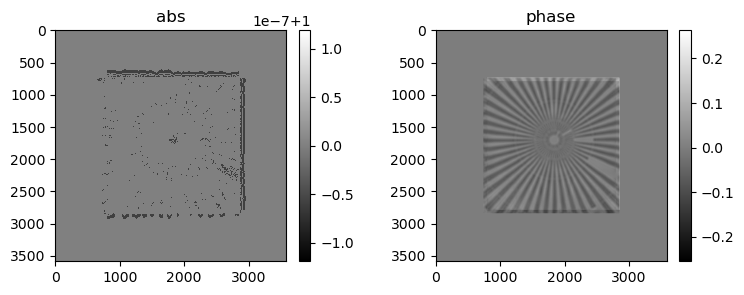

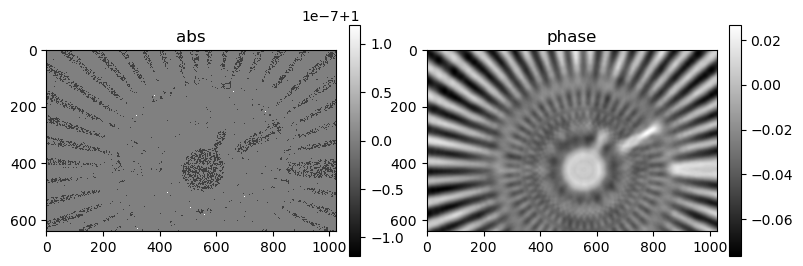

In [15]:
def rec_init(rdata,shifts):
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        rdatar = cp.array(rdata[:,j:j+1])
        r = multiPaganin(rdatar,
                            distances[j:j+1], wavelength, voxelsize,  24.05, 0.5e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)))   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)))   
        shiftsr = cp.array(shifts[:,j])
        recMultiPaganin[:,j] = ST(r,shiftsr).real
        recMultiPaganinr[:,j] = ST(rr,shiftsr).real
        
    recMultiPaganin = np.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = np.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    v = cp.ones(ne,dtype='float32')
    v[:pad] = np.sin(cp.linspace(0,1,pad)*np.pi/2)
    v[ne-pad:] = np.cos(cp.linspace(0,1,pad)*np.pi/2)
    v = np.outer(v,v)
    recMultiPaganin*=v
    recMultiPaganin = np.exp(1j*recMultiPaganin)

    return recMultiPaganin

rec_paganin = rec_init(rdata,shifts)
mshow_polar(rec_paganin[0],show)
mshow_polar(rec_paganin[0,ne//2-512:ne//2+128,ne//2-512:ne//2+512],show)

## debug functions

In [16]:
def plot_debug2(vars,etas,top,bottom,alpha,data):
    if show==False:
        return
    (psi,q,x,rho,lam) = (vars['psi'], vars['prb'], vars['shift'], vars['rho'],vars['lam'])
    (dpsi2,dq2,dx2) = (etas['psi'],etas['prb'],etas['shift'])
    npp = 7
    errt = cp.zeros(npp*2)
    errt2 = cp.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(alpha*k/(npp-1))*rho[0]*dpsi2
        qt = q+(alpha*k/(npp-1))*rho[1]*dq2
        xt = x+(alpha*k/(npp-1))*rho[2]*dx2

        fpsit = np.abs(Lop(Sop(psit,xt)*qt))-data
        gpsit = Cop(Gop(psit))
        gqt = Cop(Gop(qt))
        errt[k] = np.linalg.norm(fpsit)**2+ lam[0]*np.linalg.norm(gpsit)**2+ lam[1]*np.linalg.norm(gqt)**2
        
    t = alpha*(cp.arange(2*npp))/(npp-1)
    tmp = np.abs(Lop(Sop(psi,x)*q))-data
    gpsi = Cop(Gop(psi))
    gq = Cop(Gop(q))    
    errt2 = np.linalg.norm(tmp)**2+lam[0]*np.linalg.norm(gpsi)**2+lam[1]*np.linalg.norm(gq)**2-top*t+0.5*bottom*t**2
    
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt.get(),'.')
    plt.plot(alpha.get()*cp.arange(2*npp).get()/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts,shifts_init):
    plt.plot(shifts_init[0,:,0].get()-(shifts[0,:,0].get()),'r.')
    plt.plot(shifts_init[0,:,1].get()-(shifts[0,:,1].get()),'b.')
    plt.show()

def vis_debug(vars,data,i):
    mshow_polar(vars['psi'][0],show)
    mshow_polar(vars['psi'][0,ne//2-n//8:ne//2+n//8,ne//2+n//4:ne//2+n//2],show)
    mshow_polar(vars['prb'][0],show)
    dxchange.write_tiff(np.angle(vars['psi'][0]).get(),f'{path_out}/crec_code_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.angle(vars['prb'][0]).get(),f'{path_out}/crec_prb_angle{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['psi'][0]).get(),f'{path_out}/crec_code_abs{flg}/{i:03}',overwrite=True)
    dxchange.write_tiff(np.abs(vars['prb'][0]).get(),f'{path_out}/crec_prb_abs{flg}/{i:03}',overwrite=True)
    np.save(f'{path_out}/crec_shift{flg}_{i:03}',vars['shift'])

    
def err_debug(vars, grads, data):    
    (psi,q,x,lam) = (vars['psi'], vars['prb'], vars['shift'], vars['lam'])
    tmp = np.abs(Lop(Sop(psi,x)*q))-data
    gpsi = Cop(Gop(psi))
    gq = Cop(Gop(q))
    err = np.linalg.norm(tmp)**2+lam[0]*np.linalg.norm(gpsi)**2+lam[1]*np.linalg.norm(gq)**2

   # print(f'gradient norms (psi, prb, shift): {np.linalg.norm(grads['psi']):.2f}, {np.linalg.norm(grads['prb']):.2f}, {np.linalg.norm(grads['shift']):.2f}')                        
    return err

# Main CG loop (fifth rule)

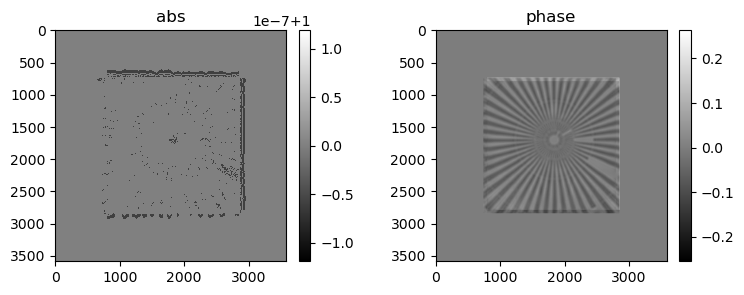

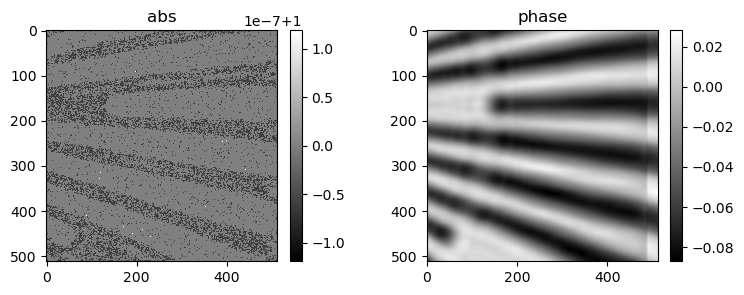

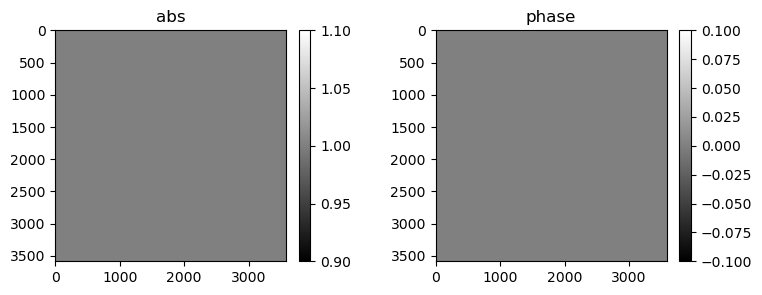

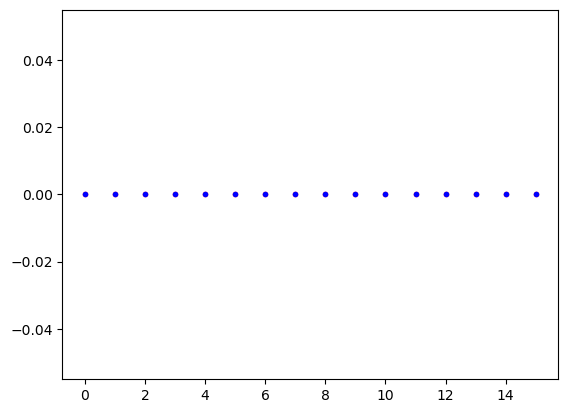

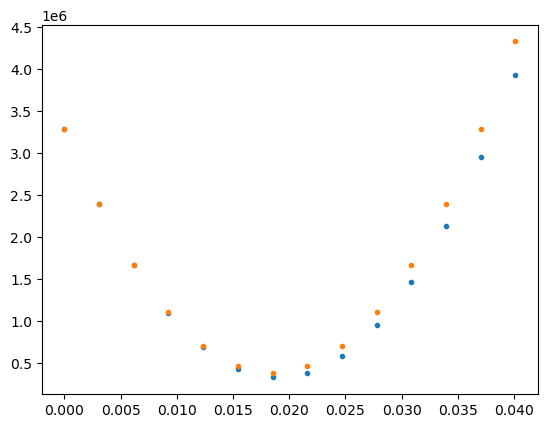

0) alpha=0.01851, [1, 1, 0.1] err=3.32154e+05


In [ ]:
def cg_holo(data, vars, pars):

    data = np.sqrt(data)    
    erra = cp.zeros(pars['niter'])
    alphaa = cp.zeros(pars['niter'])    
    shifts_init = vars['shift'].copy()
    for i in range(pars['niter']):    
        if i % pars['vis_step'] == 0 and pars['vis_step'] != -1:
            vis_debug(vars, data, i)
            if vars['rho'][2]>0:
                plot_debug3(vars['shift'],shifts_init)            
       
        gradF = gradientF(vars,data)        
        grads = gradients(vars,data,gradF)
        
        if i==0:
            etas = {}
            etas['psi'] = -grads['psi']
            etas['prb'] = -grads['prb']
            etas['shift'] = -grads['shift']
        else:      
            beta = calc_beta(vars, grads, etas, data, gradF)
            etas['psi'] = -grads['psi'] + beta*etas['psi']
            etas['prb'] = -grads['prb'] + beta*etas['prb']
            etas['shift'] = -grads['shift'] + beta*etas['shift']

        alpha,top,bottom = calc_alpha(vars, grads, etas, data, gradF) 
        if i % pars['vis_step'] == 0:
            plot_debug2(vars,etas,top,bottom,alpha,data)

        vars['psi'] += vars['rho'][0]*alpha*etas['psi']
        vars['prb'] += vars['rho'][1]*alpha*etas['prb']
        vars['shift'] += vars['rho'][2]*alpha*etas['shift']
        
        if i % pars['err_step'] == 0:
            err = err_debug(vars, grads, data)    
            print(f'{i}) {alpha=:.5f}, {vars['rho']} {err=:1.5e}',flush=True)
            erra[i] = err
            alphaa[i] = alpha

        
        # t={}
        # t[0]=np.linalg.norm(grads['psi'])
        # t[1]=np.linalg.norm(grads['prb'])
        # t[2]=np.linalg.norm(grads['shift'])
        # for k in range(1,3):
        #     if t[k]>2*t[0]:
        #         vars['rho'][k]/=2
        #     elif t[k]<t[0]/2:
        #         vars['rho'][k]*=2        
            
    return vars,erra,alphaa

vars = {}
vars['psi'] = cp.array(rec_paganin).copy()
vars['prb'] = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
vars['shift'] = cp.array(shifts)
vars['rho'] = [1,1,0.1]
vars['lam'] = [lam1,lam2]
data_rec = cp.array(data)#p.pad(cp.array(data),((0,0),(0,0),(pad,pad),(pad,pad)))

pars = {'niter': 3000, 'err_step': 64, 'vis_step': 128}
vars,erra,alphaa = cg_holo(data_rec, vars, pars)   